In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F

In [3]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
epochs = 10
batch_size = 32
lr = 0.01
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
classes = ('tshirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot')

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ])
train_val_dataset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)
ratio = 0.2
train_examples = int((1.0-ratio)*len(train_val_dataset))
val_examples = int(ratio*len(train_val_dataset))
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_val_dataset,[train_examples,val_examples])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,padding=1)
        self.conv1_drop = nn.Dropout2d(p=0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.conv2_drop = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(3136, 1200)
        self.fc2 = nn.Linear(1200,50)
        self.fc3 = nn.Linear(50,10)

    def forward(self, x):
        #x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2))
        x = F.leaky_relu(F.max_pool2d(self.conv1_drop(self.conv1(x)), 2))
        x = F.leaky_relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(-1, 320)
        x = x.view(x.size(0),-1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,1,kernel_size=2,stride=2),
            nn.Sigmoid()
        )
  
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
def train(model,device,optimizer,epoch,trainloader,criterion):
    model.train()
    epoch_loss = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print("Average training loss:",epoch_loss)
    return epoch_loss
    
def test(model,device,testloader,criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output,labels)
            epoch_loss += loss.item()
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    epoch_loss /= len(testloader)
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        epoch_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    return epoch_loss

In [ ]:
model = Classifier().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
training_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train(model,device,optimizer,epoch,trainloader,criterion)
    val_loss = test(model,device,valloader,criterion)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
print("Final performance")
plot(train_losses,val_losses,epochs)
test(model,device,testloader,criterion)


In [12]:
def train(model,device,optimizer,epoch,trainloader,criterion):
    model.train()
    epoch_loss = 0
    for index,(images,labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,images)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    epoch_loss /= len(trainloader)
    print("Average training loss:",epoch_loss)
    return epoch_loss
    
def test(model,device,testloader,criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output,images)
            epoch_loss += loss.item()
    epoch_loss /= len(testloader)
    print('Average loss: {:.4f}'.format(epoch_loss))
    return epoch_loss

def plot(training_losses,val_losses,epochs):
    plt.plot(range(epochs),training_losses,label="Training loss")
    plt.plot(range(epochs),val_losses,label="Validation loss")
    plt.legend()
    plt.title('Loss per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

Average training loss: 0.07100893073280652
Average loss: 0.0281
Average training loss: 0.03003794226795435
Average loss: 0.0202
Average training loss: 0.024806331593543292
Average loss: 0.0177
Average training loss: 0.022259413257241248
Average loss: 0.0162
Average training loss: 0.02039913502521813
Average loss: 0.0150
Average training loss: 0.018964907065033912
Average loss: 0.0142
Average training loss: 0.017882731571172674
Average loss: 0.0134
Average training loss: 0.01699098222889006
Average loss: 0.0131
Average training loss: 0.016249212333311638
Average loss: 0.0125
Average training loss: 0.015681362583612402
Average loss: 0.0122
Final performance
Average loss: 0.0122


Text(0, 0.5, 'Loss')

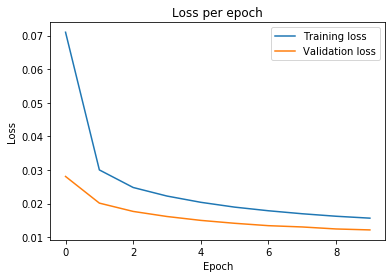

In [13]:
model = AutoEncoder().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()
training_losses = []
val_losses = []
for epoch in range(epochs):
    train_loss = train(model,device,optimizer,epoch,trainloader,criterion)
    val_loss = test(model,device,valloader,criterion)
    training_losses.append(train_loss)
    val_losses.append(val_loss)
print("Final performance")
plot(train_losses,val_losses,epochs)
test(model,device,testloader,criterion)


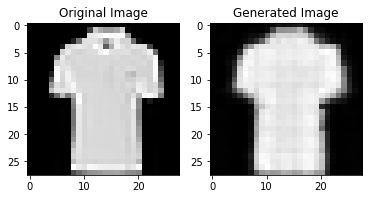

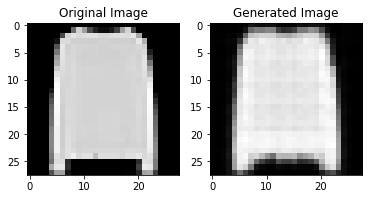

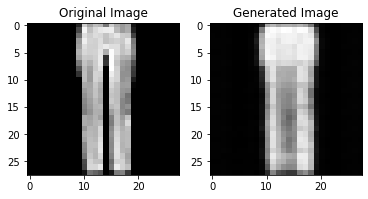

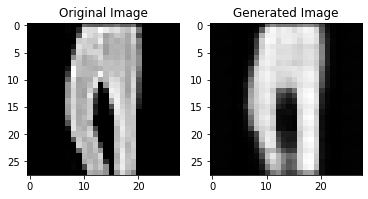

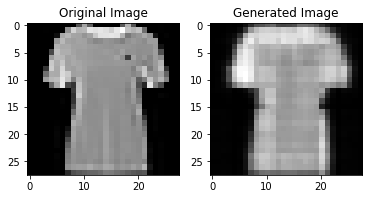

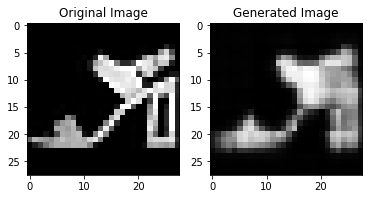

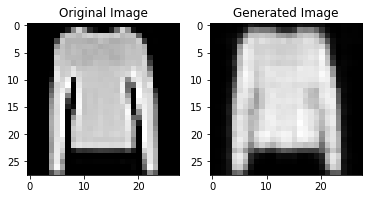

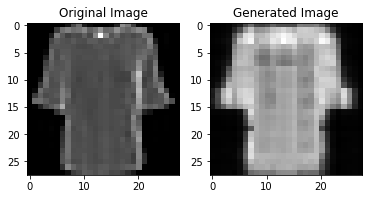

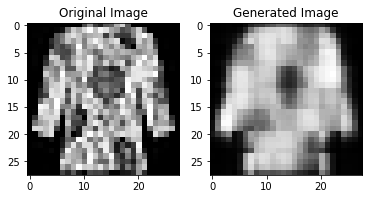

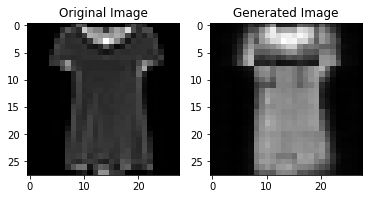

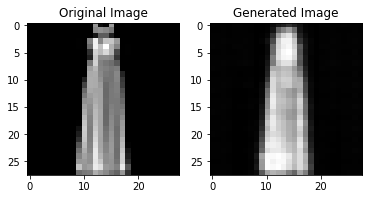

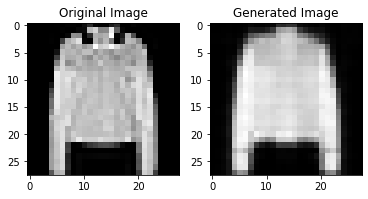

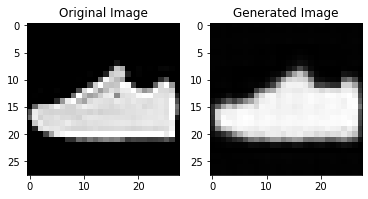

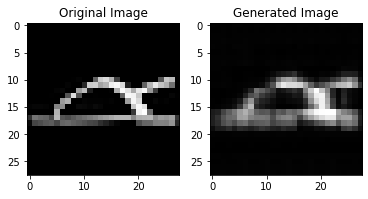

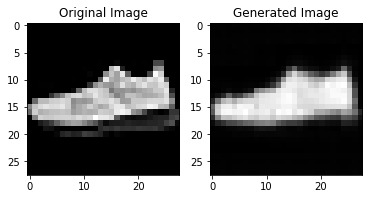

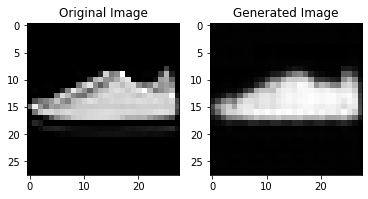

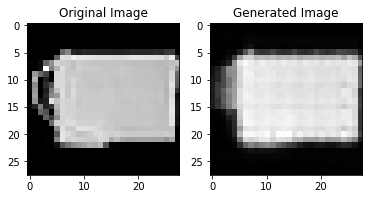

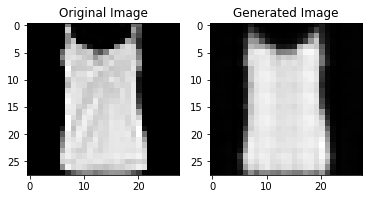

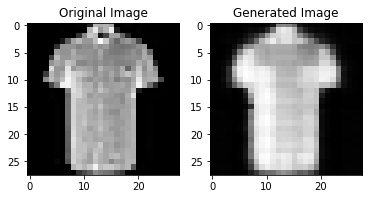

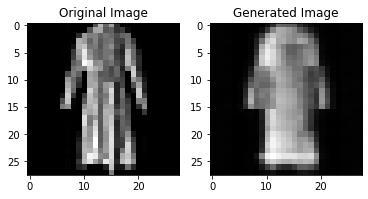

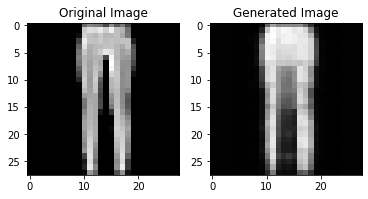

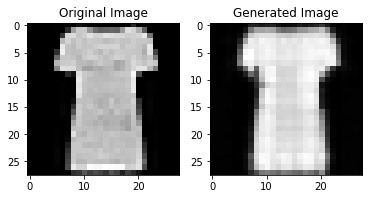

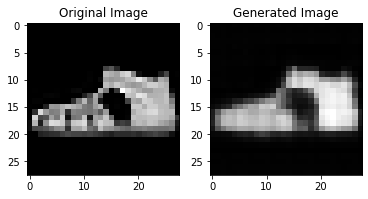

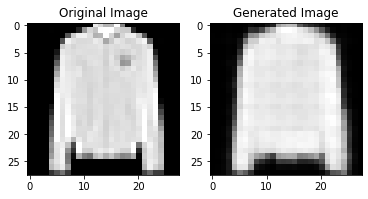

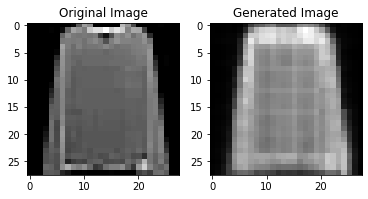

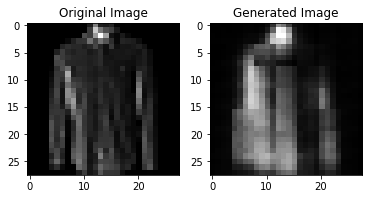

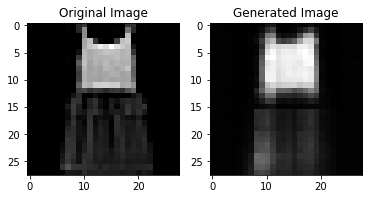

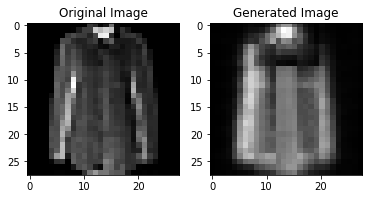

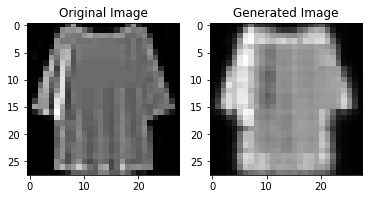

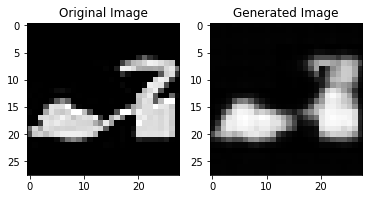

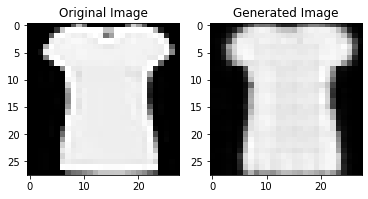

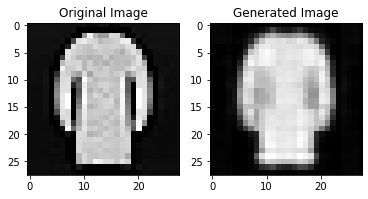

In [14]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output = model(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()